<a href="https://colab.research.google.com/github/GenoKiller777/AprendizajeSupervisado/blob/main/GrindSearch__SVM_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving titanic.csv to titanic.csv
User uploaded file "titanic.csv" with length 61194 bytes


# SVM - Caso Titanic

En este notebook, utilizaremos SVM para entrenar un algoritmo de clasificación que permita establecer un modelo que prediga los sobrevivientes del dataset Titanic

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Análisis Exploratorio

In [46]:
df = pd.read_csv('titanic.csv')

In [47]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Valores perdidos

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [49]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

La cabina no aporta mucho en el análisis, pero la edad es una variable importante para predecir si una persona sobrevivió o no a la trajedia. A continuación, una forma de "visualizar" los valores perdidos.

In [50]:
edades = round(df.groupby('Pclass').mean()['Age'])
edades

<ipython-input-50-120becd67171>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  edades = round(df.groupby('Pclass').mean()['Age'])


Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

Haremos una imputación de la edad del pasajero en función del promedio de edad de la clase en la que viajaba.

In [51]:
# creamos una funcion que imputa la edad en caso de estar nula
def imputar_edad(cols):
    edad = cols[0]
    pclass = cols[1]
    if(pd.isnull(edad)):
        if(pclass==1):
            return 38
        if(pclass==2):
            return 30
        if(pclass==3):
            return 25
    else:
        return edad

In [52]:
df['Age'] = df[['Age','Pclass']].apply(imputar_edad, axis=1)

In [53]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [105]:
df = df.dropna(subset=['Embarked'])

### Formulación del modelo

En esta sección seleccionaremos las variables que incorporaremos en la matriz de predictores "X" y en el vector de resultados "y", ya que no todas las columnas son de utilidad.

In [106]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


En el dataset de Titanic las variables disponibles son:

* PassengerId: identificador único del pasajero.

* Survived: si el pasajero sobrevivió al naufragio, codificada como 0 (no) y 1 (si). Esta es la variable respuesta que interesa predecir.

* Pclass: clase a la que pertenecía el pasajero: 1, 2 o 3.

* Name: nombre del pasajero.

* Sex: sexo del pasajero.

* Age: edad del pasajero.

* SibSp: número de hermanos, hermanas, hermanastros o hermanastras en el barco.

* Parch: número de padres e hijos en el barco.

* Ticket: identificador del billete.

* Fare: precio pagado por el billete.

* Cabin: identificador del camarote asignado al pasajero.

* Embarked: puerto en el que embarcó el pasajero.

In [107]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass          object
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [108]:
df['Pclass'] = df['Pclass'].astype('object')

#### Visuales Univariables - Cualitativas

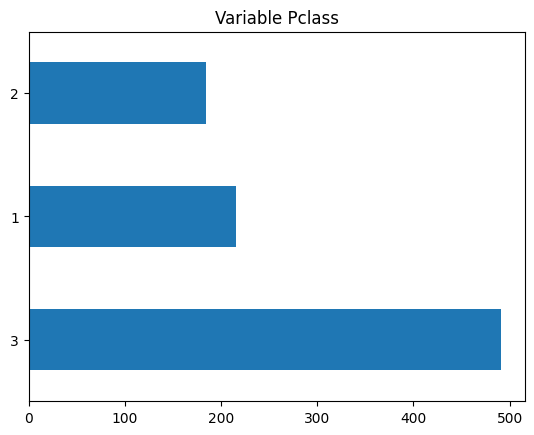

In [66]:
df['Pclass'].value_counts().plot(kind ='barh')
plt.title('Variable Pclass')
plt.show();

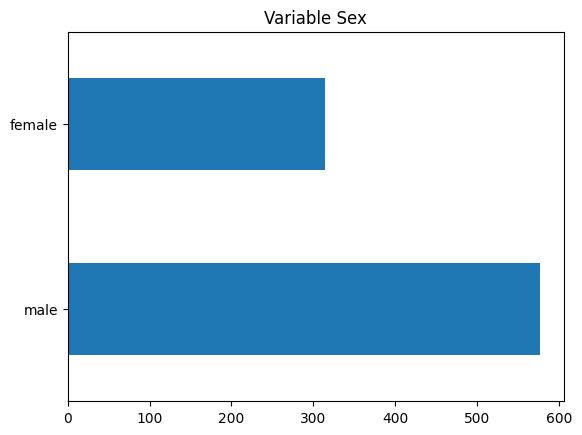

In [62]:
df['Sex'].value_counts().plot(kind ='barh')
plt.title('Variable Sex')
plt.show();

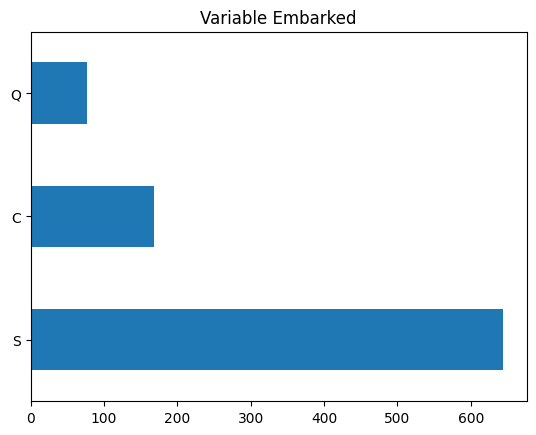

In [64]:
df['Embarked'].value_counts().plot(kind ='barh')
plt.title('Variable Embarked')
plt.show();

In [109]:
X = df[['Pclass' ,'Sex' , 'Age' ,'SibSp','Parch','Fare','Embarked']]
y = df['Survived']

In [110]:
X.dtypes

Pclass       object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

### Validación Cruzada

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    random_state=33)

### Pre Procesamientos

In [113]:
# Selección de las variables por tipo
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las
# columnas cualitativas. Para mantener las columnas a las que no se les aplica
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', drop ='first'), cat_cols)],
                remainder='passthrough')

In [114]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [115]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
nombre_columnas = np.concatenate([numeric_cols, encoded_cat])
X_train_prep = preprocessor.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=nombre_columnas)
X_train_prep.head(3)

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,-0.353633,-0.469066,-0.447805,-0.488614,0.0,1.0,1.0,0.0,1.0
1,0.026003,-0.469066,-0.447805,-0.381917,1.0,0.0,1.0,0.0,1.0
2,0.633421,0.444649,-0.447805,0.458727,0.0,0.0,0.0,0.0,1.0


### Modelamiento con SVM kernel lineal

In [118]:
from sklearn.svm import SVC

In [125]:
classifier_linear = SVC(kernel='linear', random_state=0)
classifier_linear.fit(X_train_prep, y_train)

SVC(kernel='linear', random_state=0)

#### Métricas de Evaluación

In [120]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [126]:
y_pred_linear = classifier_linear.predict(X_test_prep)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [127]:
accuracy_score(y_test,y_pred_linear)

0.8146067415730337

In [128]:
confusion_matrix(y_test,y_pred_linear)

array([[100,  11],
       [ 22,  45]])

### Modelamiento con SVM kernel rgf

In [129]:
classifier_rbf = SVC(kernel='rbf', random_state=0)
classifier_rbf.fit(X_train_prep, y_train)

SVC(random_state=0)

In [130]:
y_pred_rbf = classifier_rbf.predict(X_test_prep)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [131]:
accuracy_score(y_test,y_pred_rbf)

0.8202247191011236

In [132]:
confusion_matrix(y_test,y_pred_rbf)

array([[100,  11],
       [ 21,  46]])

### Optimice los parámetros Gamma, C (regularización), y Kernel

Para esto, utilice una grilla de búsqueda exhaustiva (GridSearchCV). Tome como referencia la siguiente documentación:

https://scikit-learn.org/stable/modules/grid_search.html

In [136]:
from sklearn.model_selection import GridSearchCV

In [137]:
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

In [148]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 5, cv = 10)

# fitting the model for grid search
grid.fit(X_train_prep, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[CV 1/10] END .............C=0.1, kernel=linear;, score=0.722 total time=   0.0s
[CV 2/10] END .............C=0.1, kernel=linear;, score=0.817 total time=   0.0s
[CV 3/10] END .............C=0.1, kernel=linear;, score=0.817 total time=   0.0s
[CV 4/10] END .............C=0.1, kernel=linear;, score=0.831 total time=   0.0s
[CV 5/10] END .............C=0.1, kernel=linear;, score=0.761 total time=   0.0s
[CV 6/10] END .............C=0.1, kernel=linear;, score=0.845 total time=   0.0s
[CV 7/10] END .............C=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 8/10] END .............C=0.1, kernel=linear;, score=0.775 total time=   0.0s
[CV 9/10] END .............C=0.1, kernel=linear;, score=0.732 total time=   0.0s
[CV 10/10] END ............C=0.1, kernel=linear;, score=0.803 total time=   0.0s
[CV 1/10] END ...............C=1, kernel=linear;, score=0.708 total time=   0.0s
[CV 2/10] END ...............C=1, kernel=linea

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
             verbose=5)

In [149]:
# imprime el mejor parámetro después del ajuste
print(grid.best_params_)

# imprime cómo se ve nuestro modelo después del ajuste de hiperparámetros
print(grid.best_estimator_)

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1000, gamma=0.001)


In [150]:
y_pred_grindsearch = grid.predict(X_test_prep)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [230]:
y_pred_grindsearch

array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [151]:
confusion_matrix(y_test,y_pred_grindsearch)

array([[103,   8],
       [ 22,  45]])

In [152]:
from sklearn.metrics import classification_report

# Imprime el classification report
print(classification_report(y_test, y_pred_grindsearch))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87       111
           1       0.85      0.67      0.75        67

    accuracy                           0.83       178
   macro avg       0.84      0.80      0.81       178
weighted avg       0.83      0.83      0.83       178



## Nueva Predicción

In [214]:
new_predict = [{'Pclass': 1, 'Sex': 'male', 'Age': 33, 'SibSp': 1, 'Parch': 2, 'Fare': 77.5 ,'Embarked': 'Q'},
               {'Pclass': 3, 'Sex': 'male', 'Age': 77, 'SibSp': 3, 'Parch': 0, 'Fare': 120 ,'Embarked': 'C'},
               {'Pclass': 2, 'Sex': 'female', 'Age': 27, 'SibSp': 4, 'Parch': 1, 'Fare': 33 ,'Embarked': 'S'}]

In [215]:
new_predict = pd.DataFrame(new_predict)
new_predict

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,33,1,2,77.5,Q
1,3,male,77,3,0,120.0,C
2,2,female,27,4,1,33.0,S


In [216]:
new_predict['Pclass'] = new_predict['Pclass'].astype('object')

In [217]:
new_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    3 non-null      object 
 1   Sex       3 non-null      object 
 2   Age       3 non-null      int64  
 3   SibSp     3 non-null      int64  
 4   Parch     3 non-null      int64  
 5   Fare      3 non-null      float64
 6   Embarked  3 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 296.0+ bytes


In [228]:
numeric_cols = new_predict.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = new_predict.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor_new = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', drop ='first'), cat_cols)],
                remainder='passthrough')

new_predict_prep = preprocessor_new.fit_transform(new_predict)
new_predict_prep = pd.DataFrame(new_predict_prep, columns=nombre_columnas)
new_predict_prep.head(3)

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,-0.568241,-1.336306,1.224745,0.018768,0.0,0.0,1.0,1.0,0.0
1,1.405649,0.267261,-1.224745,1.215253,0.0,1.0,1.0,0.0,0.0
2,-0.837408,1.069045,0.000000,-1.234021,1.0,0.0,0.0,0.0,1.0


In [231]:
pred_new = grid.best_estimator_.predict(new_predict_prep)

In [234]:
new_predict

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,male,33,1,2,77.5,Q
1,3,male,77,3,0,120.0,C
2,2,female,27,4,1,33.0,S


In [233]:
pred_new
# No Sobrevive
# No Sobrevive
# Si Sobrevive

array([0, 0, 1])